In [1]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

In [2]:
signal = sio.loadmat('EMG_only_s41.mat')
signal

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sat Nov 12 20:43:29 2022',
 '__version__': '1.0',
 '__globals__': [],
 'x_left': array([[-350009.25, -349878.5 , -350106.75, ..., -278221.  , -278275.5 ,
         -278582.25],
        [-817651.  , -817499.5 , -817587.75, ..., -623848.5 , -623918.  ,
         -624214.25],
        [-782868.  , -783068.  , -782909.  , ..., -583269.25, -583265.25,
         -583058.75],
        [-766947.  , -766631.75, -766685.  , ..., -627494.5 , -627589.25,
         -627328.  ]], dtype=float32),
 'x_right': array([[-351785.75, -351616.  , -351778.  , ..., -278058.5 , -277717.5 ,
         -277276.  ],
        [-823036.5 , -822781.5 , -822878.25, ..., -620703.5 , -620302.75,
         -619903.  ],
        [-785281.5 , -785276.  , -785294.5 , ..., -585409.75, -585482.75,
         -585849.75],
        [-767641.25, -767701.25, -768015.75, ..., -627718.75, -627733.5 ,
         -628203.25]], dtype=float32)}

In [3]:
print(signal["x_left"].shape)

(4, 358400)


In [4]:
200*68*512*7

48742400

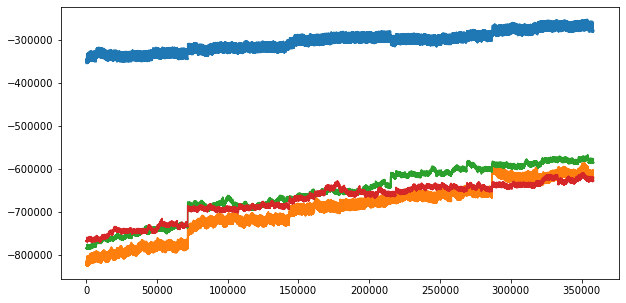

In [5]:
right=signal["x_right"]
all_right_2d =signal["x_right"]
plt.figure(figsize = (10,5))
plot = plt.plot(right[0:4,:].T)

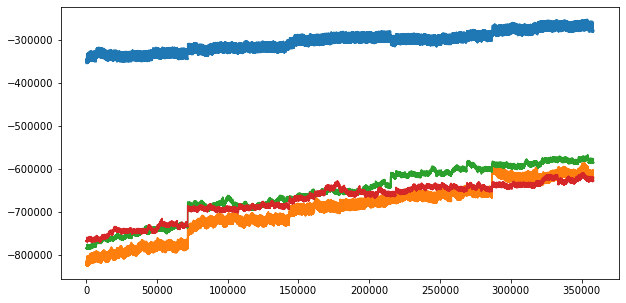

In [6]:
right=signal["x_right"]
# right = right[64:68,:]
right = right.reshape(100,4,512*7)
# right = right[:,64:68,:]
right.shape
plt.figure(figsize = (10,5))
plot = plt.plot(right.reshape((4,512*100*7)).T)

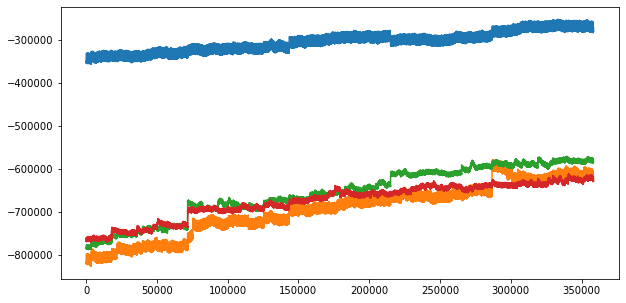

In [7]:
left = signal["x_left"]
all_left_2d = signal["x_left"]

# left = left[64:68,:]
left = left.reshape(100,4,512*7)
plt.figure(figsize=(10,5))
plot = plt.plot(left.reshape((4,100*512*7)).T)

In [8]:

run = np.concatenate((left,right),axis=0)
y_right= np.zeros(100);y_left = np.ones(100)# 0 = derecha //// 1 = izquierda
y = np.concatenate((y_left,y_right),axis=0)
left.shape, right.shape, run.shape, y.shape

((100, 4, 3584), (100, 4, 3584), (200, 4, 3584), (200,))

In [9]:
(1,right[1,:,:].shape)

(1, (4, 3584))

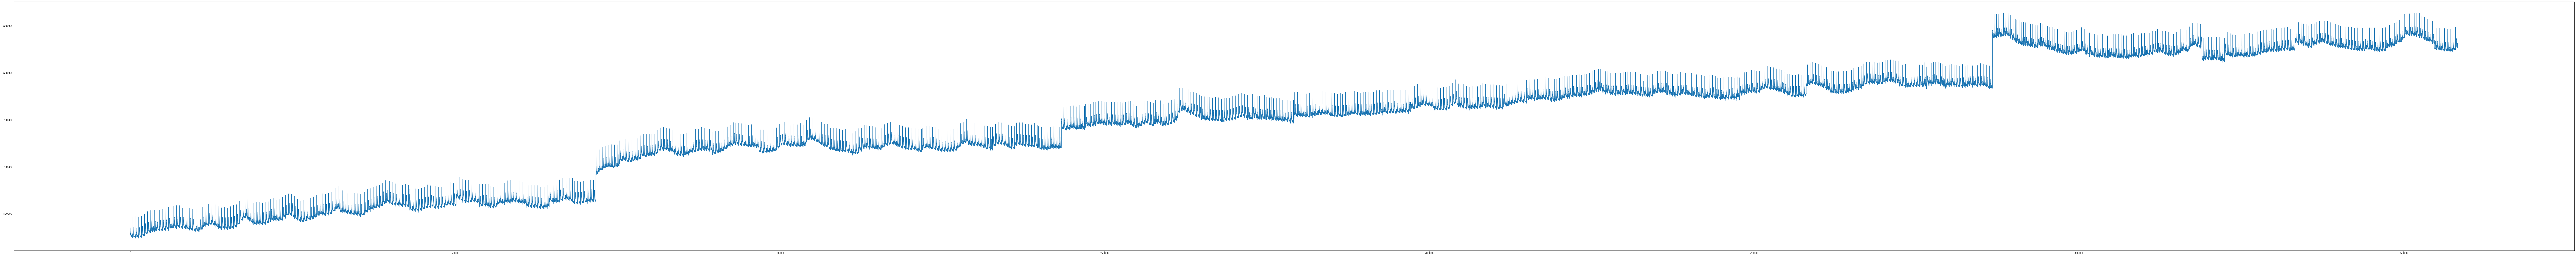

In [10]:
plt.figure(figsize=(200,20))
right_ = right.reshape(4,512*100*7)
plot = plt.plot(right_[1,:])
# plt.figsize(100,220)

# Plotear 2 ensayos distintos

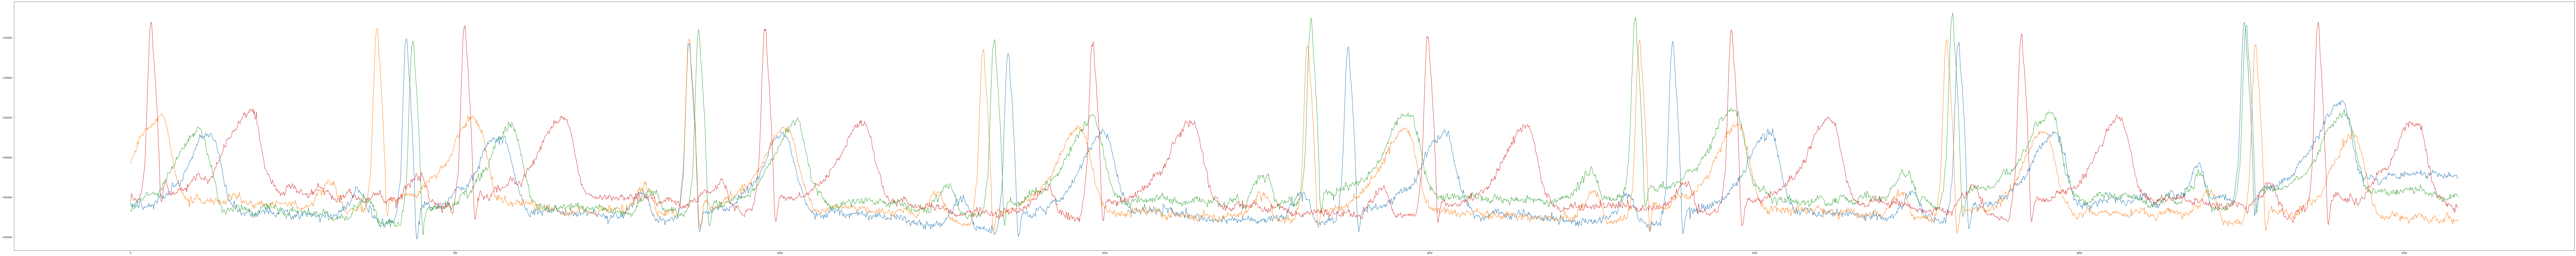

In [11]:
run_ = run.reshape(200,4,512*7)
plt.figure(figsize=(200,20))
plot =plt.plot(run_[1,:,:].T)

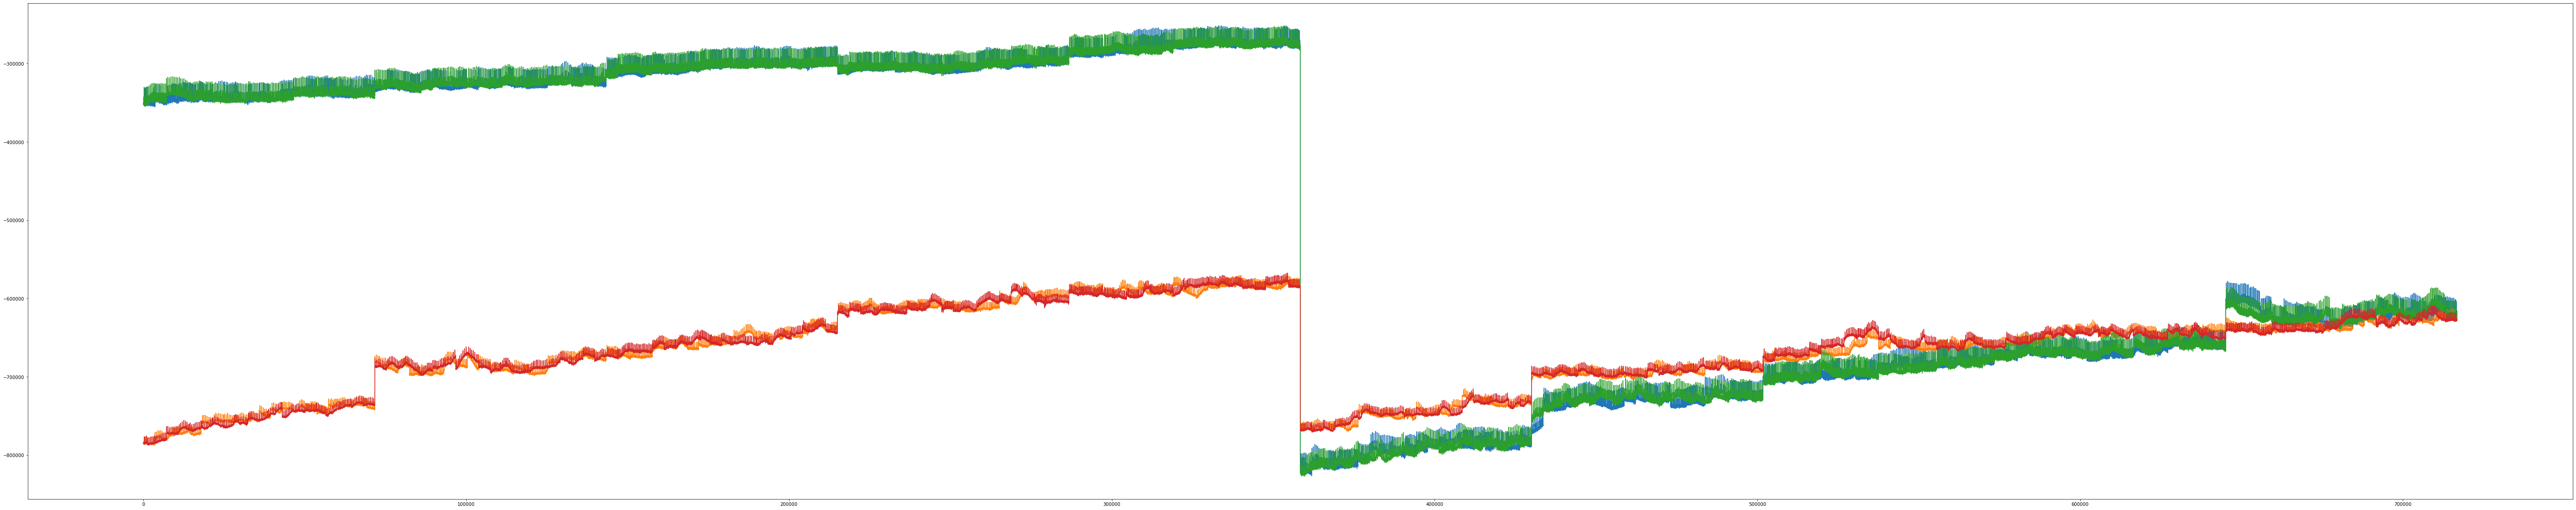

In [12]:
plt.figure(figsize=(100,20))
plot = plt.plot(run_.reshape((4,512*7*200)).T)

# Estandarizar

In [13]:
run_[1,:,:].shape
np.arange(9)
x = np.ones((10,40))
x[1,:] = x[1,:]-1
run_[1,:,:].shape

(4, 3584)

In [14]:

def estandarizarCanal(channelArray):#shape (canales x tiempo)
    avg  = np.average(channelArray,axis = 1)
    # print(avg)
    std = np.std(channelArray,axis = 1)
    for i in range(4):  
        channelArray[i,:] = (channelArray[i,:]-avg[i])/std[i]
    # print(avg.shape, std.shape)
    # channelArray = (channelArray-avg)#/std
    #avg = avg.reshape(*avg.shape, 1)
    #avg.shape
    return channelArray

def estandarizarCanales(completeRun):
    for i in range(completeRun.shape[0]):
        completeRun[i,:,:] = estandarizarCanal(completeRun[i,:,:])
    return completeRun

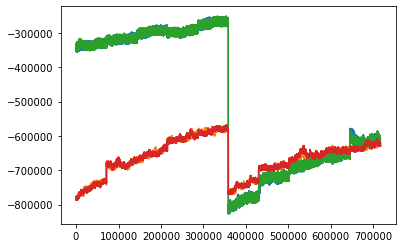

In [15]:
_ = plt.plot(run.reshape((4,512*200*7)).T)

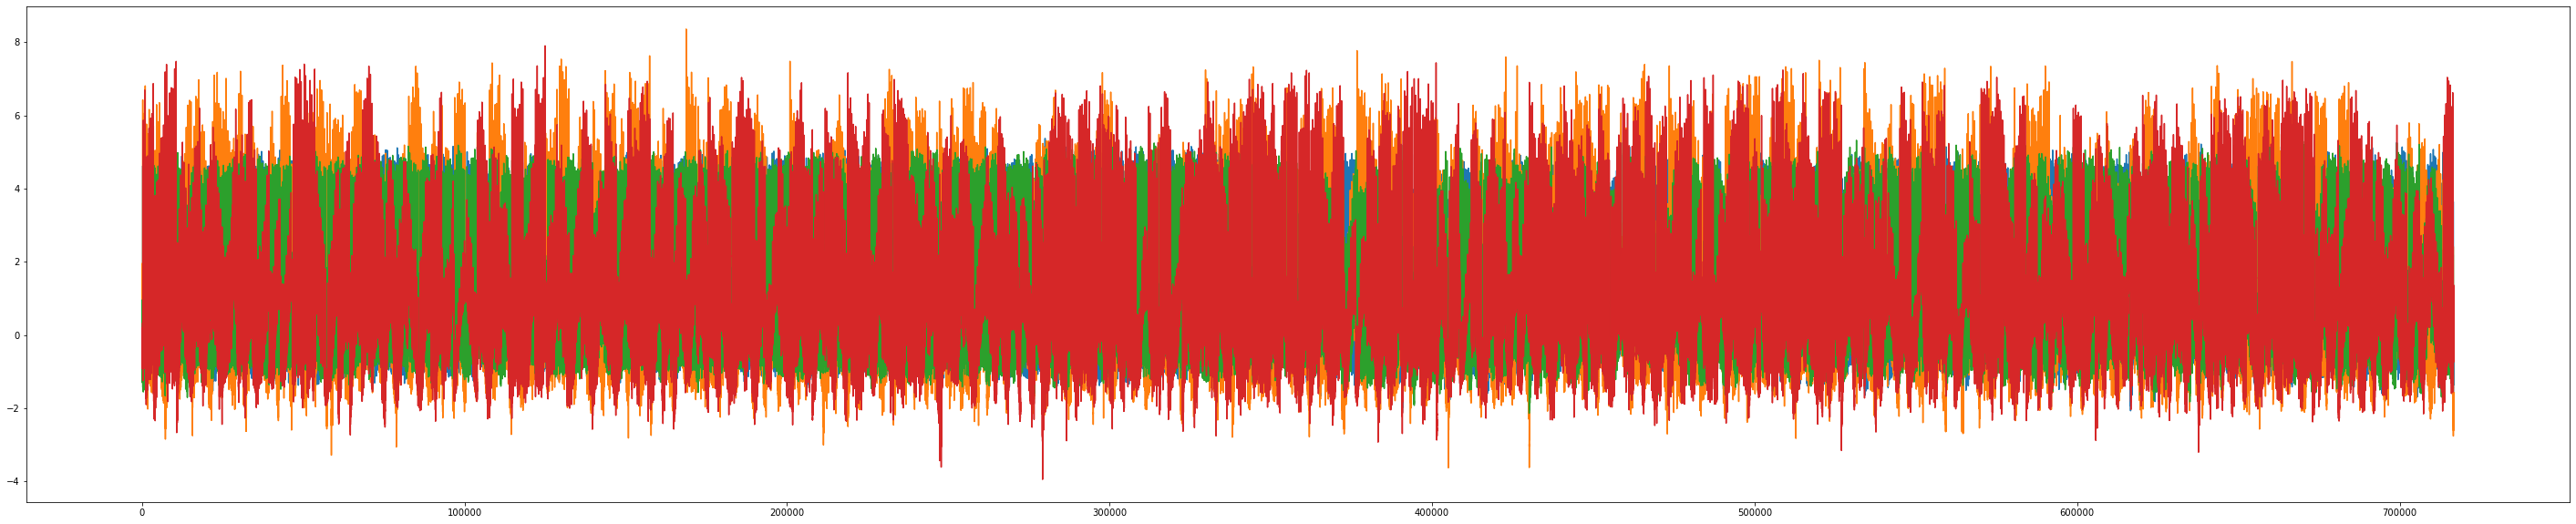

In [49]:

trial = estandarizarCanales(run_)
# plt.figure(figsize = (200,50))
plt.figure(figsize = (50,10))
_ = plt.plot(trial.reshape((4,512*200*7)).T)

In [17]:
train_len = 160
test_len = 40
input_shape = (train_len, 4,512*7,1)
num_classes = 2
# plt.plot(run_.T)
run_.shape

(200, 4, 3584)

In [18]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow as tf

rand_i = np.random.choice(200, 200, replace=False)

x_train = run_[rand_i[0:160]]
y_train = y[rand_i[0:160]]
x_test = run_[rand_i[0:160]]
y_test = y[rand_i[160:200]]
x_test = run_[rand_i[160:200]]

y_train = keras.utils.to_categorical(y_train,num_classes)
y_test = keras.utils.to_categorical(y_test,num_classes)
x_train.shape, y_train.shape, x_test.shape, y_test.shape


((160, 4, 3584), (160, 2), (40, 4, 3584), (40, 2))

In [48]:

np.savetxt('exampMini.csv', x_test[1,:,:], delimiter=',')
emg=np.loadtxt('exampMini.csv',delimiter=',')
emg = emg.reshape((1,4,512*7))
out = model.predict(emg)
type(out), out.shape
np.array2string(out)

1/1 [==============================] - 0s 33ms/step


'[[9.9987710e-01 1.2290348e-04]]'

In [19]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape[1:]),
        layers.Conv2D(32, kernel_size=(2,100), activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2),padding = 'same'),
        layers.Conv2D(64, kernel_size=(1), activation="relu"),
        layers.MaxPooling2D(pool_size=(1)),
        layers.Flatten(),
        layers.Dropout(0.5),
     
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 3, 3485, 32)       6432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 2, 1743, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 1743, 64)       2112      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 1743, 64)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 223104)            0         
                                                                 
 dropout (Dropout)           (None, 223104)            0

In [20]:
batch_size = 5
epochs = 10
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy",tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [21]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/10
29/29 [==============================] - 3s 87ms/step - loss: 1.6803 - accuracy: 0.5764 - recall: 0.5764 - precision: 0.5764 - val_loss: 0.8814 - val_accuracy: 0.5625 - val_recall: 0.5625 - val_precision: 0.5625
Epoch 2/10
29/29 [==============================] - 3s 94ms/step - loss: 0.1927 - accuracy: 0.9236 - recall: 0.9236 - precision: 0.9236 - val_loss: 0.2351 - val_accuracy: 0.9375 - val_recall: 0.9375 - val_precision: 0.9375
Epoch 3/10
29/29 [==============================] - 3s 93ms/step - loss: 0.0475 - accuracy: 0.9931 - recall: 0.9931 - precision: 0.9931 - val_loss: 0.1050 - val_accuracy: 0.9375 - val_recall: 0.9375 - val_precision: 0.9375
Epoch 4/10
29/29 [==============================] - 2s 78ms/step - loss: 0.0014 - accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000 - val_loss: 0.0378 - val_accuracy: 1.0000 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 5/10
29/29 [==============================] - 2s 75ms/step - loss: 6.2342e-04 - accuracy: 1.0000 - rec

In [22]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])
score


Test loss: 0.0263905581086874
Test accuracy: 1.0


INFO:tensorflow:Assets written to: path/to/location/assets


INFO:tensorflow:Assets written to: path/to/location/assets


In [26]:

model.save('CNN_1.h5')


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.preprocessing import compute_proj_ecg
from mne_connectivity import envelope_correlation
import pandas as pd
run_

df = pd.DataFrame(np.concatenate((all_left_2d,all_right_2d),axis = 1))
df.shape

(4, 716800)

In [24]:
df.shape[0]*['emg']
sf = 512
ch_types = ["emg"]*df.shape[0]
chanels = ['brazo_1','brazo_2','brazo_3','brazo_4']
info = mne.create_info(ch_names = chanels ,sfreq=sf,ch_types=ch_types)
#montage = mne.channels.make_standard_montage('biosemi64')
print(df.shape)
samples = df*1e-6 #pasar a voltios asumiendo que las unidades del dataset son microvoltios

loadedRaw = mne.io.RawArray(samples, info)
# loadedRaw.set_montage(montage = montage)
plt.figure(figsize=(21,150))  
loadedRaw.info
epochs = mne.make_fixed_length_epochs(loadedRaw, duration=1, preload=False)
epochs = epochs.get_data()
epochs.shape

(4, 716800)
Creating RawArray with float64 data, n_channels=4, n_times=716800
    Range : 0 ... 716799 =      0.000 ...  1399.998 secs
Ready.
Not setting metadata
1400 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1400 events and 512 original time points ...
0 bad epochs dropped


(1400, 4, 512)

<Figure size 1512x10800 with 0 Axes>

# Otro modelo

In [25]:
model2 = True
## Load labelled EMG sessions to train on
# selected = ['esic_82','cise_38','iecs_45']
# x, y = np.empty((0, L, 4), np.float32), np.empty((0, 4), np.float32)
# for k in selected:
#     x = np.append(x,sessions[k][0],axis=0)
#     y = np.append(y,sessions[k][1],axis=0)

### Downsample, shuffle and split (from sklearn.cross_validation)
# x_train, x_val, y_train, y_val = train_test_split((x[:,::ds,:]), y, test_size=0.25)
input_shape = (train_len, 4,512*7)

### Create the network
model2 = keras.Sequential()
model2.add(layers.Conv1D(40, 10, strides=2, padding='same', activation='relu', input_shape=input_shape[1:]))
model2.add(layers.Dropout(0.2))
model2.add(layers.MaxPooling1D(3))
model2.add(layers.Conv1D(40, 5, strides=2, padding='same', activation='relu'))
model2.add(layers.Dropout(0.2))
model2.add(layers.MaxPooling1D(3))
model2.add(layers.Conv1D(40, 4, strides=1, padding='same', activation='relu'))
model2.add(layers.Dropout(0.2))
model2.add(layers.MaxPooling1D(3))
model2.add(layers.GlobalAveragePooling1D())
model2.add(layers.Dense(50, activation='relu'))
model2.add(layers.Dropout(0.2))
model2.add(layers.Dense(num_classes, activation='softmax'))

model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### Train and save results for later plotting
history[ '40 1023 523 413 50 :'+'-'.join(selected)] = model2.fit(x_train, y_train, 
    batch_size=100, epochs=40)

ValueError: Exception encountered when calling layer "max_pooling1d" (type MaxPooling1D).

Negative dimension size caused by subtracting 3 from 2 for '{{node max_pooling1d/MaxPool}} = MaxPool[T=DT_FLOAT, data_format="NHWC", explicit_paddings=[], ksize=[1, 3, 1, 1], padding="VALID", strides=[1, 3, 1, 1]](max_pooling1d/ExpandDims)' with input shapes: [?,2,1,40].

Call arguments received by layer "max_pooling1d" (type MaxPooling1D):
  • inputs=tf.Tensor(shape=(None, 2, 40), dtype=float32)

In [ ]:
layers.MaxPooling1D(3).pool_size